In [1]:
from mcmc.particle_gibbs import ParticleGibbs, PGSamples, PGConfig
from mcmc.rwmh import RandomWalkMH, RWMHConfig, MatrixRWMH, CovarianceRWMH

from feynmac_kac.protocol import CSMC, PFOutputs, PFConfig
from feynmac_kac.bootstrap import ConditionalBPF

from model.lgssm import LGSSMModel
from utils.datasets import load_dataset

from dynamax.linear_gaussian_ssm import lgssm_filter
from dynamax.linear_gaussian_ssm import LinearGaussianSSM as dmax_LGSSM

from jax import Array
import jax.random as jr
import jax.numpy as jnp

In [2]:
def exact_filter(data):
    
    # get true filter means using Kalman filter
    dmax_lgssm = dmax_LGSSM(data.train_states.shape[-1], data.train_data[0].shape[-1])
    params, _ = dmax_lgssm.initialize(
        jr.PRNGKey(0),
        initial_mean=data.params['m1'],
        initial_covariance=data.params['Q1'],
        dynamics_weights=data.params['A'],
        dynamics_covariance=data.params['Q'],
        emission_weights=data.params['C'],
        emission_covariance=data.params['R']
    )
    x, y = data.train_states[0], data.train_data[0][0]
    lgssm_posterior = lgssm_filter(params, y)
    print("Exact filter means shape: ", lgssm_posterior.filtered_means.shape)
    return lgssm_posterior

In [12]:
# param names should match those of params in the used model
A_cfg = RWMHConfig(name="A", scale=2, n_burn=500, adaptive=True)
C_cfg = RWMHConfig(name="C", scale=2, n_burn=500, adaptive=True)
Q_cfg = RWMHConfig(name="Q", scale=2, n_burn=500, adaptive=True)
R_cfg = RWMHConfig(name="R", scale=2, n_burn=500, adaptive=True)

# Random Walk samplers
A_rwmh = MatrixRWMH(A_cfg, means=jnp.eye(1), sigma=2)
C_rwmh = MatrixRWMH(C_cfg, means=0.5*jnp.eye(1), sigma=2)
Q_rwmh = CovarianceRWMH(Q_cfg, psi=0.5, nu=4.0)
R_rwmh = CovarianceRWMH(R_cfg, psi=0.5, nu=4.0)
# Q_rwmh = RandomWalkMH(Q_cfg)
# R_rwmh = RandomWalkMH(R_cfg)

# samplers = [A_rwmh, Q_rwmh, C_rwmh, R_rwmh]
samplers = [A_rwmh, C_rwmh ]

In [4]:
class LinearGaussianParticleGibbs(ParticleGibbs):
    """
    Run Particle Gibbs on LGSSM
    """
    def __init__(self, csmc: CSMC, cfg: PGConfig, samplers: list):
        super().__init__(csmc, cfg)
        self.samplers = samplers
    
    def update_params(self, key, curr_params: dict, outs: PFOutputs, obs: Array, x_imm: Array):

        new_params = {}
        
        for sampler in self.samplers:
            key, subkey = jr.split(key)
            curr = curr_params.get(sampler.cfg.name)
            key, new  = sampler.sample(subkey, curr, self.csmc.model, x_imm, obs)
            new_params[sampler.cfg.name] = new
        return new_params
        

In [5]:
# data
data = load_dataset('linear_small', seed=0)
lgssm_posterior = exact_filter(data)
x, y = data.train_states[0], data.train_data[0][0]

Exact filter means shape:  (300, 1)


In [6]:
data.params

{'m1': Array([0.], dtype=float32),
 'Q1': Array([[1.]], dtype=float32),
 'A': Array([[0.7324345]], dtype=float32),
 'b': Array([0.], dtype=float32),
 'Q': Array([[0.46353966]], dtype=float32),
 'R': Array([[0.31622776]], dtype=float32),
 'C': Array([[0.4194783]], dtype=float32),
 'd': Array([-0.6027049], dtype=float32)}

In [7]:
def random_psd_matrix(key, dim, scale=0.1, eps=1e-5):
    """
    Generate a random symmetric positive definite matrix.
    """
    A = jr.normal(key, (dim, dim)) * scale
    Q = A @ A.T + eps * jnp.eye(dim)
    return Q


# random initial params
key = jr.PRNGKey(112)
params = {}
for name, val in data.params.items():
    key, subkey = jr.split(key)
    shape = val.shape

    if name in ["Q", "R", "Q1"]:  # covariance or initial covariance matrices
        d = shape[0]  # assume square
        params[name] = random_psd_matrix(subkey, d, scale=1)
    else:
        # for weights, means, etc. just random normal around 0
        params[name] = jr.normal(subkey, shape=shape) * 0.3

# params["m1"] = data.params["m1"]
# params["Q1"] = data.params["Q1"]
# params["b"] = data.params["b"]
# params["Q"] = data.params["Q"]
# params["R"] = data.params["R"]
# params["C"] = data.params["C"]
# params["d"] = data.params["d"]
params

{'m1': Array([-0.08785383], dtype=float32),
 'Q1': Array([[0.04181907]], dtype=float32),
 'A': Array([[0.05570832]], dtype=float32),
 'b': Array([0.07755627], dtype=float32),
 'Q': Array([[2.6203117]], dtype=float32),
 'R': Array([[0.33522707]], dtype=float32),
 'C': Array([[0.2912706]], dtype=float32),
 'd': Array([0.3150193], dtype=float32)}

In [8]:
lgssm = LGSSMModel(params)
csmc = ConditionalBPF(
    model=lgssm,
    config=PFConfig(
        N=1000,
        resample_scheme='multinomial',
        ess_threshold=0.3,
        key=jr.PRNGKey(42)
    )
)
cfg = PGConfig(n_iters=1000, T=x.shape[0], key=jr.PRNGKey(101), backward_sample=True)

lgssm_pg = LinearGaussianParticleGibbs(csmc, cfg, samplers)

In [9]:
pg_samples, pf_outs = lgssm_pg.run(y)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [07:15<00:00,  2.29it/s, log likelihood=-1.04e+3]


In [30]:
pg_samples.thetas["Q"][-1]

Array([[3.0193684]], dtype=float32)

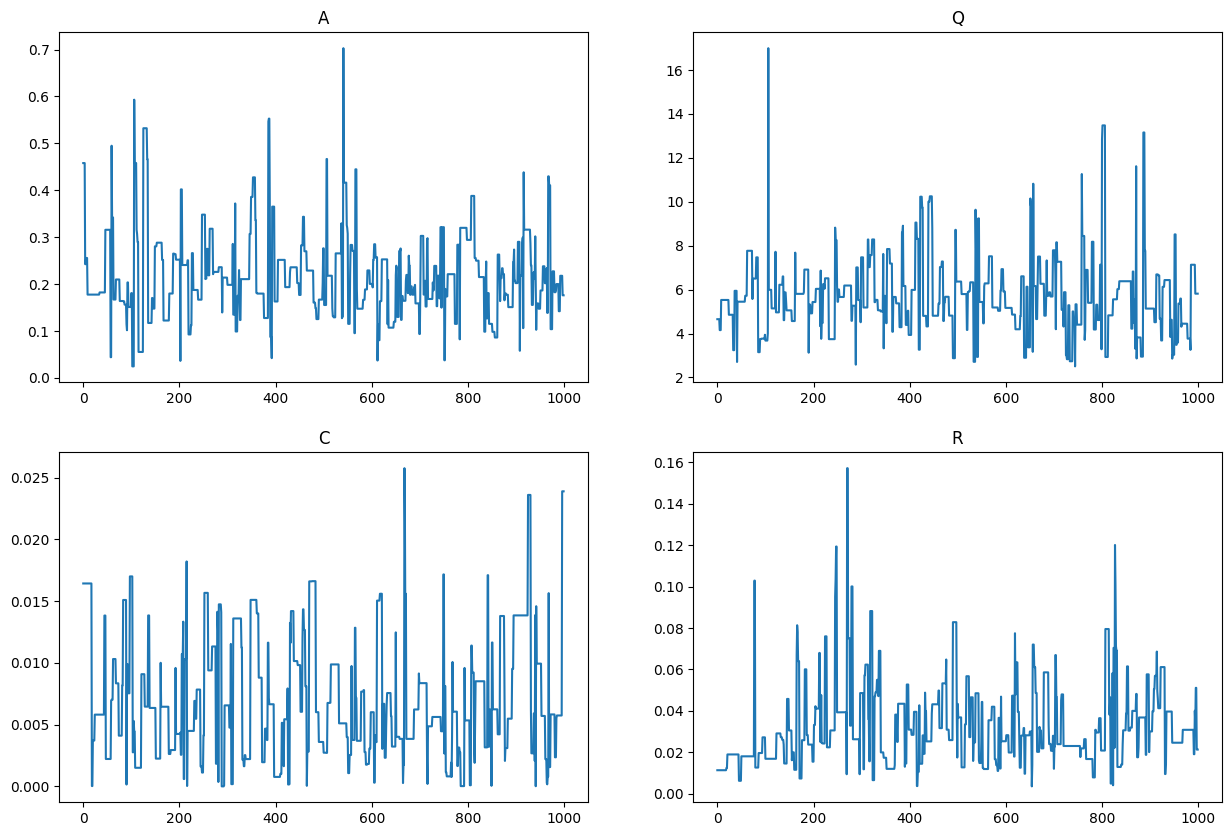

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax[0, 0].plot(((data.params["A"] - pg_samples.thetas["A"])**2)[:, :, 0])
ax[0, 0].set_title("A")
ax[0, 1].plot(((data.params["Q"] - pg_samples.thetas["Q"])**2)[:, :, 0])
ax[0, 1].set_title("Q")
ax[1, 0].plot(((data.params["C"] - pg_samples.thetas["C"])**2)[:, :, 0])
ax[1, 0].set_title("C")
ax[1, 1].plot(((data.params["R"] - pg_samples.thetas["R"])**2)[:, :, 0])
ax[1, 1].set_title("R")
plt.show()

In [43]:
pg_samples.thetas["R"][900:].mean(axis=0)

Array([[0.5133159]], dtype=float32)

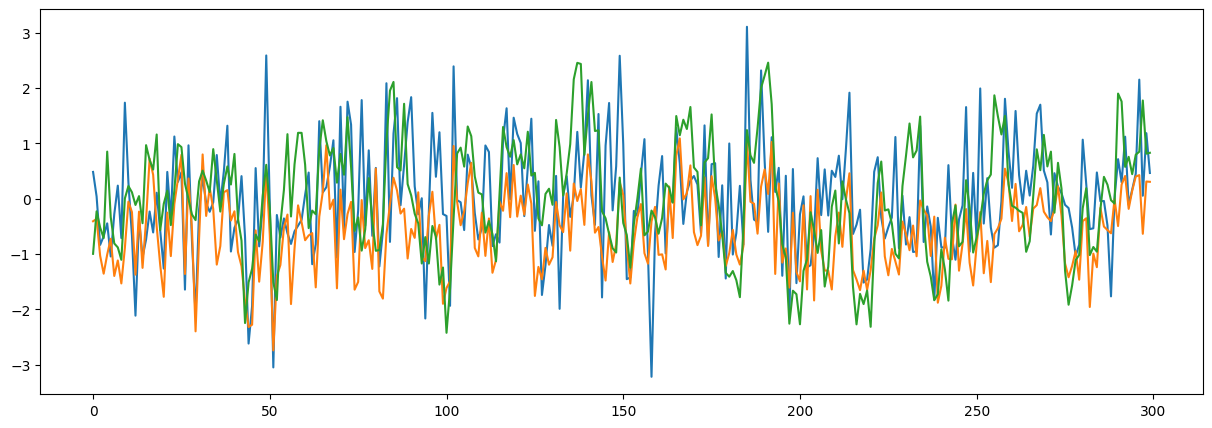

In [15]:
x_imm = pg_samples.x_paths[-1]
plt.figure(figsize=(15, 5))
plt.plot((x_imm - x_imm.mean()) / x_imm.std())
plt.plot(y)
plt.plot((x - x.mean()) / x.std())
plt.show()

In [16]:
pg_samples

PGSamples(thetas={'A': Array([[[ 0.05570832]],

       [[ 0.05570832]],

       [[ 0.05570832]],

       [[ 0.05570832]],

       [[ 0.2401195 ]],

       [[ 0.2401195 ]],

       [[ 0.22685838]],

       [[ 0.22685838]],

       [[ 0.22685838]],

       [[ 0.31110767]],

       [[ 0.31110767]],

       [[ 0.31110767]],

       [[ 0.31110767]],

       [[ 0.31110767]],

       [[ 0.31110767]],

       [[ 0.31110767]],

       [[ 0.31110767]],

       [[ 0.31110767]],

       [[ 0.31110767]],

       [[ 0.31110767]],

       [[ 0.31110767]],

       [[ 0.31110767]],

       [[ 0.31110767]],

       [[ 0.31110767]],

       [[ 0.31110767]],

       [[ 0.31110767]],

       [[ 0.31110767]],

       [[ 0.31110767]],

       [[ 0.31110767]],

       [[ 0.31110767]],

       [[ 0.31110767]],

       [[ 0.31110767]],

       [[ 0.31110767]],

       [[ 0.31110767]],

       [[ 0.30566826]],

       [[ 0.30566826]],

       [[ 0.30566826]],

       [[ 0.30566826]],

       [[ 0.30566826]],

  